## Implementation of a Wilson-Cowan system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, block_diag
import ipywidgets as widgets
# Unscented Kalman Filter (UKF) applied to FitzHugh-Nagumo neuron dynamics.

### Wilson-Cowan model 

we use the equations (like 6.7 in the book) in the form used in 
 Schiff SJ, Sauer T. Kalman filter control of a model of spatiotemporal cortical dynamics. J Neural Eng. 2008 Mar 15;5(1):1–8. 


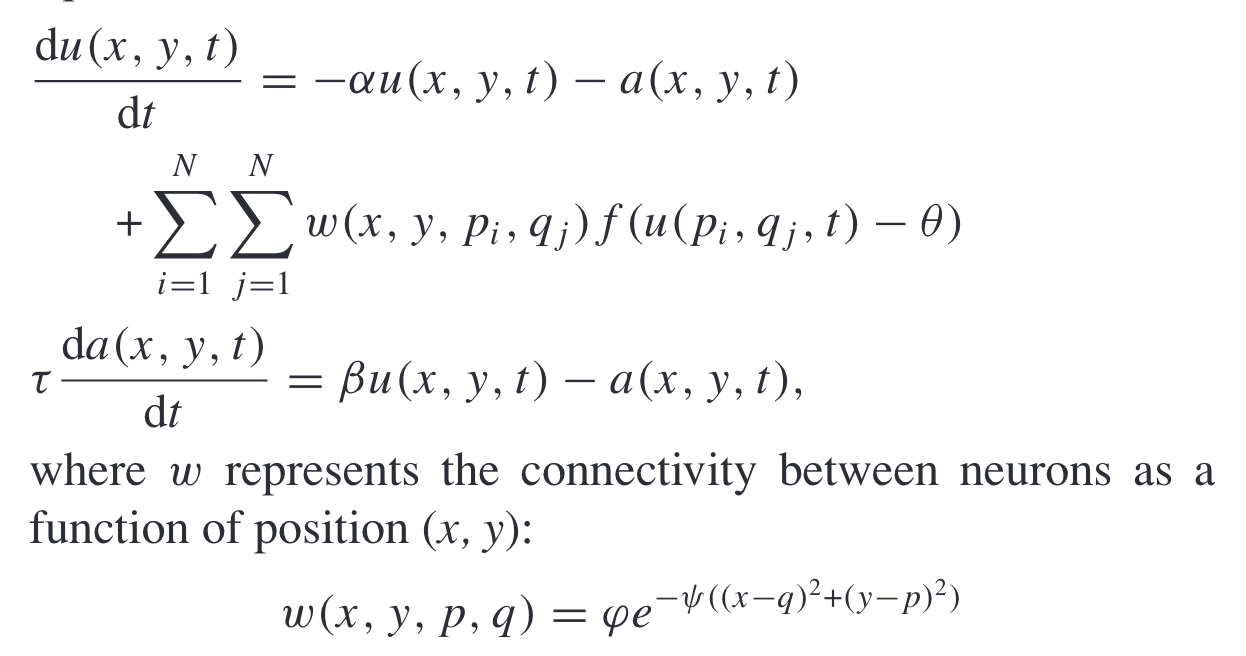

In [2]:
# Define parameters
q = 2  # or any value up to 12 
Threshold = 0.1  # firing threshold 
numsteps = 200  # number of iterations
B = 1000 # beta in the equations above
C = 15 # inverse time constant for u (\alpha in the equations above)
p = 8  # number of columns in the grid
n = 8  # number of rows in the grid
K = 10  # input gain for u (\phi in equations above) 
k = 0.05  # inverse spread of connectivity (\psi in the equations abovce) 
delt = 0.001  # integration interval 
tau = 0.01  # time constant for a 

In [3]:
# Initialize variables


u0 = np.array([
    [-0.1637, -0.2244, -0.1982, -0.1410, -0.1029, -0.0811, -0.0656, -0.0396],
    [-0.2593, -0.3580, -0.3021, -0.2008, -0.1321, -0.1028, -0.0840, -0.0516],
    [-0.2444, -0.3386, -0.2746, -0.1726, -0.0950, -0.0742, -0.0637, -0.0417],
    [-0.0055, -0.0383, 0.0012, -0.0657, -0.0395, -0.0388, -0.0387, -0.0270],
    [0.2361, 0.3685, 0.2616, 0.2237, 0.0279, -0.0174, -0.0239, -0.0183],
    [0.4698, 0.7002, 0.5627, 0.2726, 0.0939, -0.0071, -0.0171, -0.0135],
    [0.3618, 0.5613, 0.4323, 0.2754, 0.0673, -0.0056, -0.0130, -0.0104],
    [0.2442, 0.2669, 0.2571, 0.1067, 0.0152, -0.0049, -0.0077, -0.0061]
])

a0 = np.array([
    [0.4104, 0.5339, 0.4345, 0.2786, 0.1904, 0.1454, 0.1157, 0.0694],
    [0.7058, 0.9183, 0.6974, 0.4049, 0.2427, 0.1821, 0.1465, 0.0893],
    [0.9263, 1.1846, 0.8515, 0.4104, 0.1757, 0.1283, 0.1085, 0.0707],
    [1.0750, 1.4204, 1.0146, 0.4695, 0.0921, 0.0646, 0.0636, 0.0444],
    [1.0367, 1.4612, 0.9507, 0.4993, 0.0532, 0.0309, 0.0380, 0.0293],
    [0.7878, 1.1079, 0.7914, 0.3707, 0.0468, 0.0205, 0.0267, 0.0213],
    [0.4156, 0.5573, 0.4218, 0.1886, 0.0255, 0.0150, 0.0202, 0.0162],
    [0.1386, 0.1823, 0.1406, 0.0437, 0.0083, 0.0090, 0.0119, 0.0095]
])

n, p = u0.shape

Text(0.5, 1.0, 'a(0)')

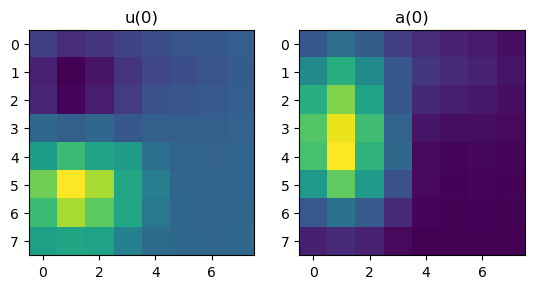

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(u0)
ax1.set_title('u(0)')
ax2.imshow(a0)
ax2.set_title('a(0)')


In [5]:
# Main loop
ue_tot = np.zeros((n, p, numsteps))
integ = np.zeros((n, p))
for step in range(numsteps):
    ue = np.concatenate((np.zeros((p, q)), u0, np.zeros((p, q))), axis=1)
    ue = np.concatenate((np.zeros((q, n + 2 * q)), ue, np.zeros((q, n + 2 * q))), axis=0)
    for i in range(-q, q + 1):
        for j in range(-q, q + 1):
            integ += K * np.exp(-k * (i**2 + j**2)) * \
            (ue[i+q:i+n+q, j+q:j+p+q] > Threshold)

    integ -= K * (u0 > Threshold)  # Subtract self-input
    a1 = a0 + delt * (np.dot(B, u0) - a0) / tau
    u1 = u0 - delt * np.dot(C, u0) - delt * a0 + delt * integ

    u0 = u1
    a0 = a1

    ue_tot[:,:,step] = u0

# Plotting example (replace with your specific#  plotting routine)
# plt.imshow(u0, cmap='viridis')
# plt.colorbar()
# plt.show()

You should see a traveling wave here

In [6]:
@widgets.interact(i=(0, numsteps-1))
def img_render(i=0):
    plt.imshow(ue_tot[:,:,i])
    plt.clim(0, ue_tot.max()/2)

interactive(children=(IntSlider(value=0, description='i', max=199), Output()), _dom_classes=('widget-interact'…

Normalizing the amplitude of each frame to see the wave better 

In [7]:
@widgets.interact(i=(0, numsteps-1))
def img_render(i=0):
    plt.imshow(ue_tot[:,:,i])
    plt.clim(0, ue_tot[:,:,i].max())

interactive(children=(IntSlider(value=0, description='i', max=199), Output()), _dom_classes=('widget-interact'…

In [11]:
# Unscented transformation. Not specific to FitzHugh-Nagumo model
def ut(xhat, Pxx, y, fct, obsfct, dq, dx, dy, R):

    N = 2 * dx
    
    xsigma = sqrtm(dx * Pxx).T  # Pxx = root * root', but Pxx = chol' * chol
    Xa = xhat[:, np.newaxis] + np.hstack([xsigma, -xsigma])
    X = fct(dq, Xa)

    xtilde = np.mean(X, axis=1)  # same as xtilde = np.sum(X, axis=1) / N

    Pxx = np.zeros((dx, dx))
    for i in range(N):
        Pxx += np.outer((X[:, i] - xtilde), (X[:, i] - xtilde)) / N

    Y = np.atleast_2d(obsfct(X))

    ytilde = np.mean(Y, axis=1)
    Pyy = R.copy()
    for i in range(N):
        Pyy += np.outer((Y[:, i] - ytilde), (Y[:, i] - ytilde)) / N

    Pxy = np.zeros((dx, dy))
    for i in range(N):
        Pxy += np.outer((X[:, i] - xtilde), (Y[:, i] - ytilde)) / N

    K = np.dot(Pxy, np.linalg.inv(Pyy))  # same as K = np.dot(Pxy, np.linalg.inv(Pyy))
    xhat = xtilde + np.dot(K, (y - ytilde))
    Pxx = Pxx - np.dot(K, Pxy.T)

    Pxx = (Pxx + Pxx.T) / 2. + ip * np.eye(Pxx.shape[0]) # covariance inflation

    return xhat, Pxx, K